<a href="https://colab.research.google.com/github/Jswirls/rookie_fantasy_proj/blob/main/NFL_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install nfl_data_py

In [ ]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np

# Data


In [ ]:
seasons = [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
prev_seasons = [2007, 2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]

In [ ]:
drafted_players = nfl.import_draft_picks(seasons)
rookies = drafted_players[((drafted_players['position'] == 'QB') | (drafted_players['position'] == 'RB') | (drafted_players['position'] == 'WR') | (drafted_players['position'] == 'TE'))]
rookies = rookies.drop(['player_id', 'side', 'category'], axis = 1)

In [ ]:
f_data = nfl.import_seasonal_data(seasons)
prev_qb = nfl.import_qbr(prev_seasons)
depth_chart = nfl.import_depth_charts(seasons)
coaches = pd.read_csv('https://raw.githubusercontent.com/cooperdff/nfl_data_py/main/data/coaching_history.csv')
RAS = pd.read_csv('https://raw.githubusercontent.com/Jswirls/rookie_fantasy_proj/main/data/ras.csv',encoding='cp1252')
coach_pass_rate = pd.read_csv('https://raw.githubusercontent.com/Jswirls/rookie_fantasy_proj/main/data/pr.csv')

In [ ]:
coaches = coaches[['coach','team','season']].drop_duplicates(subset = ['team','season'],keep = 'first')
coaches['team'] = coaches['team'].replace(['GNB','KAN','NOR','NWE','SDG','LAR','TAM','LVR','SFO'], ['GB','KC','NO','NE','SD','LA','TB','LV','SF'])
coaches = coaches.merge(coach_pass_rate,how='left',on='coach')

ids = nfl.import_ids(ids=['gsis'])
ids = ids[['gsis_id', 'draft_year','draft_ovr']]
ids = ids.rename(columns={'draft_year' : 'season', 'draft_ovr' : 'pick'})

#rookies = rookies.drop(['gsis_id'],axis=1)
rookies = rookies.merge(ids,how='left',on=['season','pick'])
rookies = rookies[rookies['gsis_id'].notna()]

depth_chart = depth_chart[['gsis_id','season','team','depth_team','week']]
depth_chart = depth_chart.where(depth_chart['week'] == 1)
depth_chart = depth_chart.drop('week', axis=1)
depth_chart= depth_chart.dropna()

RAS = RAS.rename(columns={'Year' : 'season', 'Position' : 'position','Name':'pfr_name'})
rookies = rookies.merge(RAS, how='left',on=['season','position','pfr_name'])
rookies = rookies.merge(coaches, how='left',on=['team','season'])
rookies = rookies.merge(depth_chart, how='left',on=['gsis_id','season','team']).drop_duplicates(subset = ['pfr_name','season','team'], keep= 'last')
rookies['depth_team'] = rookies['depth_team'].replace([1.0, 2.0, 3.0,np.nan], ['First','Second','Third','NA'])

qb_depth_chart = nfl.import_depth_charts(seasons)
qb_depth_chart = qb_depth_chart[['full_name','season','team','depth_team','week','position']]
qb_depth_chart = qb_depth_chart[(qb_depth_chart['position']=='QB') & (qb_depth_chart['depth_team']==1) & (qb_depth_chart['week']==1)]
qb_depth_chart = qb_depth_chart.drop(['week','position','depth_team'],axis =1).drop_duplicates()

prev_qb = prev_qb[prev_qb['season_type'] == 'Regular']
prev_qb = prev_qb[['season','team_abb','name_display','qbr_total','epa_total','pass','run']]
prev_qb['season'] = prev_qb['season'].astype(int) + 1

qb_depth_chart = qb_depth_chart.merge(prev_qb,how = 'left', left_on = ['season','full_name'], right_on = ['season','name_display'])
mean_qb = nfl.import_qbr(prev_seasons)
mean_qb = mean_qb[mean_qb['season_type'] == 'Regular']
mean_qb = mean_qb[['season','team_abb','name_display','qbr_total','epa_total','pass','run']]

drafted_players = nfl.import_draft_picks(prev_seasons)

qbrookies = drafted_players[(drafted_players['position'] == 'QB')]
qbrookies = qbrookies.drop(['player_id', 'side', 'category'], axis = 1)
qbrookies = qbrookies.merge(mean_qb,how='left',left_on=['pfr_name','season'],right_on=['name_display','season']).drop(['pfr_id','position','team_abb','name_display'],axis=1)

early_qb = qbrookies.where(qbrookies['pick'] <= 32).dropna(subset=['pfr_name']).fillna(0)
mid_qb = qbrookies.where((qbrookies['pick'] <= 100) & (qbrookies['pick'] > 32)).dropna(subset=['pfr_name']).fillna(0)
late_qb = qbrookies.where((qbrookies['pick'] > 100)).dropna(subset=['pfr_name']).fillna(0)
early_mean = early_qb[['qbr_total','epa_total','pass','run']].mean()
mid_mean = mid_qb[['qbr_total','epa_total','pass','run']].mean()
late_mean = late_qb[['qbr_total','epa_total','pass','run']].mean()

qb_depth_chart=qb_depth_chart.drop(['name_display','team_abb','full_name'],axis=1)

rookies = rookies.merge(qb_depth_chart,how='left', on = ['season','team'])
rookies.loc[(rookies['position'] == 'QB') & (rookies['round'] == 1), ['qbr_total','epa_total','pass','run']] = round(early_mean['qbr_total'],1), round(early_mean['epa_total'],1), round(early_mean['pass'],1), round(early_mean['run'],1)
rookies.loc[(rookies['position'] == 'QB') & (rookies['pick'] > 32) & (rookies['pick'] <= 100), ['qbr_total','epa_total','pass','run']] = round(mid_mean['qbr_total'],1), round(mid_mean['epa_total'],1), round(mid_mean['pass'],1), round(mid_mean['run'],1)
rookies.loc[(rookies['position'] == 'QB') & (rookies['pick'] > 100), ['qbr_total','epa_total','pass','run']] = round(late_mean['qbr_total'],1), round(late_mean['epa_total'],1), round(late_mean['pass'],1), round(late_mean['run'],1)
rookies.loc[rookies['qbr_total'].isnull(), ['qbr_total','epa_total','pass','run']] = round(early_mean['qbr_total'],1), round(early_mean['epa_total'],1), round(early_mean['pass'],1), round(early_mean['run'],1)

f_data = f_data[(f_data['season_type'] == 'REG')]
f_data = f_data[['player_id','season','fantasy_points']]
rookies = rookies.rename(columns={'pass' : 'qb_pass_epa', 'run' : 'qb_run_epa', 'pfr_name': 'name', 'gsis_id': 'player_id'})
rookies = rookies.merge(f_data, how='left',on =['player_id','season'])
rookies['fantasy_points'] = rookies['fantasy_points'].fillna(0)
rookies['pass_rate'] = rookies['pass_rate'].fillna(rookies['pass_rate'].mean())

rookies

,season,team,round,pick,pfr_id,name,position,player_id,ALRAS,RAS,coach,pass_rate,depth_team,qbr_total,epa_total,qb_pass_epa,qb_run_epa,fantasy_points
0,2008,ATL,1,3,RyanMa00,Matt Ryan,QB,00-0026143,5.09,5.77,Mike Smith,0.594112,First,39.4,26.9,10.2,5.6,196.00
1,2008,OAK,1,4,McFaDa00,Darren McFadden,RB,00-0026144,9.65,9.60,Tom Cable,0.537030,Second,39.4,26.9,10.2,5.6,100.40
2,2008,CAR,1,13,StewJo00,Jonathan Stewart,RB,00-0026153,9.93,9.89,John Fox,0.550024,Second,55.8,8.6,5.5,-0.5,146.20
3,2008,BAL,1,18,FlacJo00,Joe Flacco,QB,00-0026158,7.79,8.14,John Harbaugh,0.549888,First,39.4,26.9,10.2,5.6,183.24
4,2008,DAL,1,22,JoneFe00,Felix Jones,RB,00-0026162,8.23,8.12,Wade Phillips,0.605357,Second,39.4,26.9,10.2,5.6,51.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,2020,MIN,7,244,StanNa00,Nate Stanley,QB,00-0036279,NaN,NaN,Mike Zimmer,0.570798,NA,4.0,1.5,0.9,0.3,0.00
909,2020,TB,7,245,CalaRa00,Raymond Calais,RB,00-0036435,NaN,NaN,Bruce Arians,0.619753,NA,55.7,61.0,40.0,4.5,0.00
910,2020,MIA,7,246,PerrMa00,Malcolm Perry,RB,00-0036245,NaN,NaN,Brian Flores,0.626792,Third,68.3,70.7,47.6,6.3,15.70
911,2020,SEA,7,251,SullSt00,Stephen Sullivan,TE,00-0036438,NaN,NaN,Pete Carroll,0.545203,NA,71.5,90.9,58.3,10.6,0.00


In [ ]:
data = rookies[['season','team','pick','name','position','RAS','coach','pass_rate','depth_team','qbr_total','epa_total','qb_pass_epa','qb_run_epa','fantasy_points']]
positions = data.groupby('position')
qbs = positions.get_group('QB')
rbs = positions.get_group('RB')
wrs = positions.get_group('WR')
tes = positions.get_group('TE')

qbs = qbs.drop(['qbr_total','epa_total','qb_pass_epa','qb_run_epa'],axis=1)
qb_e_mean = qbs[(qbs['pick'] >= 32)]['RAS'].mean()
qb_m_mean = qbs[(qbs['pick'] <= 100) & (qbs['pick'] > 32)]['RAS'].mean()
qb_l_mean = qbs[(qbs['pick'] > 100)]['RAS'].mean()
rb_e_mean = rbs[(rbs['pick'] >= 32)]['RAS'].mean()
rb_m_mean = rbs[(rbs['pick'] <= 100) & (rbs['pick'] > 32)]['RAS'].mean()
rb_l_mean = rbs[(rbs['pick'] > 100)]['RAS'].mean()
wr_e_mean = wrs[(wrs['pick'] >= 32)]['RAS'].mean()
wr_m_mean = wrs[(wrs['pick'] <= 100) & (wrs['pick'] > 32)]['RAS'].mean()
wr_l_mean = wrs[(wrs['pick'] > 100)]['RAS'].mean()
te_e_mean = tes[(tes['pick'] >= 32)]['RAS'].mean()
te_m_mean = tes[(tes['pick'] <= 100) & (tes['pick'] > 32)]['RAS'].mean()
te_l_mean = tes[(tes['pick'] > 100)]['RAS'].mean()

In [ ]:
def setRAS(row, e_mean,m_mean,l_mean):
  if row['RAS'] == 0:
    if row['pick'] <= 32:
      return e_mean
    elif row['pick'] > 100:
      return l_mean
    else:
      return m_mean
  else:
    return row['RAS']

In [ ]:
qbs['RAS'] = qbs['RAS'].fillna(0)
rbs['RAS'] = rbs['RAS'].fillna(0)
wrs['RAS'] = wrs['RAS'].fillna(0)
tes['RAS'] = tes['RAS'].fillna(0)
qbs['RAS'] = qbs.apply(
    lambda row: setRAS(row,qb_e_mean,qb_m_mean,qb_l_mean),
    axis=1
)
rbs['RAS'] = rbs.apply(
    lambda row: setRAS(row,rb_e_mean,rb_m_mean,rb_l_mean),
    axis=1
)
wrs['RAS'] = wrs.apply(
    lambda row: setRAS(row,wr_e_mean,wr_m_mean,wr_l_mean),
    axis=1
)
tes['RAS'] = tes.apply(
    lambda row: setRAS(row,te_e_mean,te_m_mean,te_l_mean),
    axis=1
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
qbs = qbs.drop_duplicates(keep='last',subset=['name','team','pick']).drop(['position','season'], axis=1)
rbs = rbs.drop_duplicates(keep='last',subset=['name','team','pick']).drop(['position','season'], axis=1)
wrs = wrs.drop_duplicates(keep='last',subset=['name','team','pick']).drop(['position','season'], axis=1)
tes = tes.drop_duplicates(keep='last',subset=['name','team','pick']).drop(['position','season'], axis=1)

This section just shows how I got my data by how I combined data from various sources.

# EDA

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

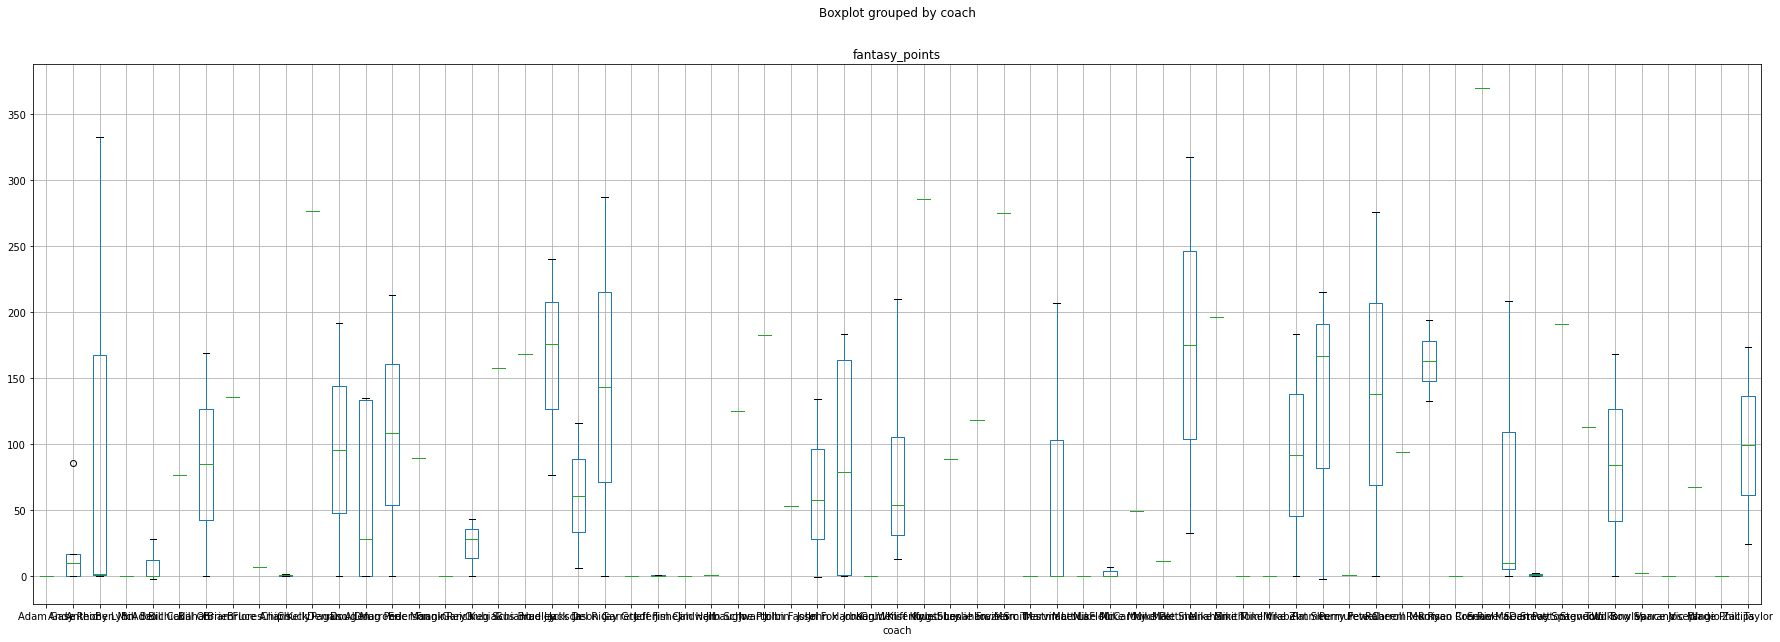

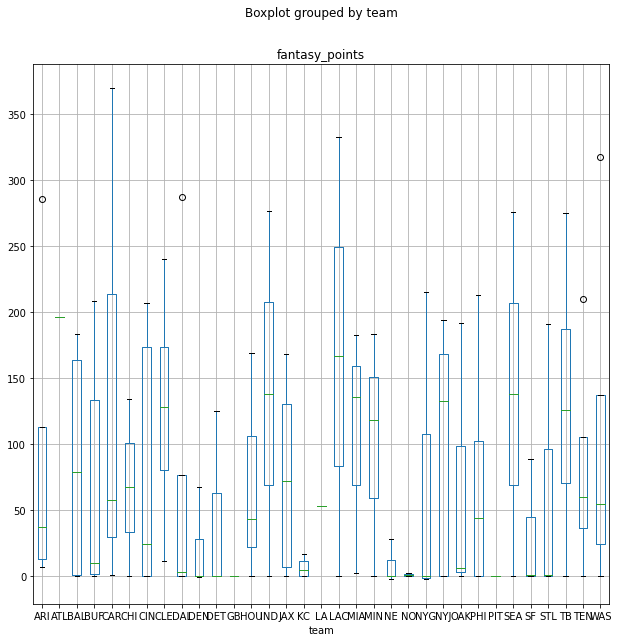

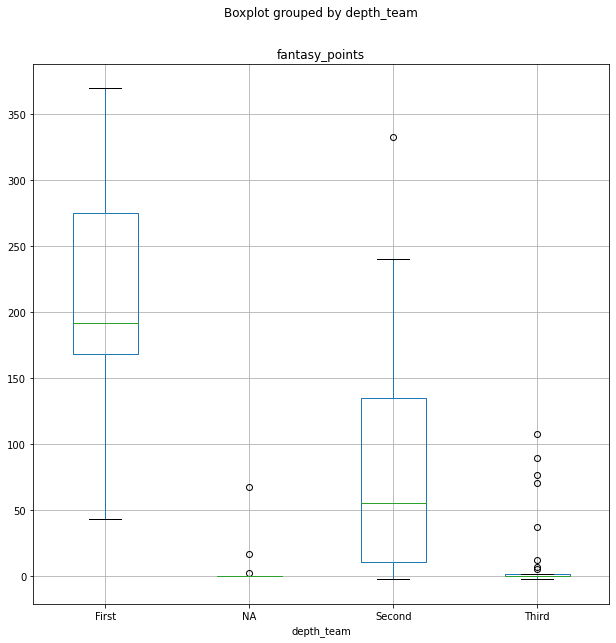

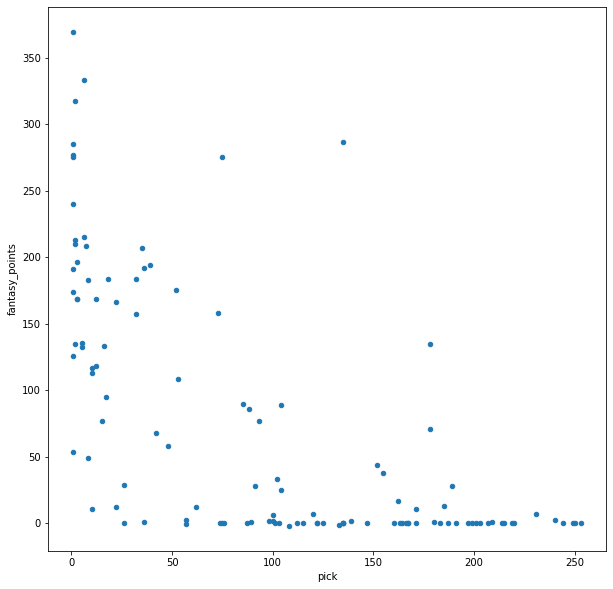

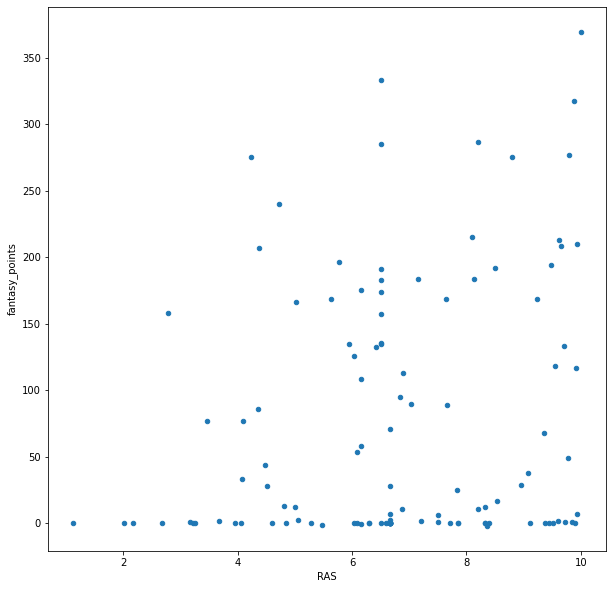

In [ ]:
qbs.boxplot(column='fantasy_points', by='coach',figsize=(30,10))
qbs.boxplot(column='fantasy_points', by='team',figsize=(10,10))
qbs.boxplot(column='fantasy_points', by='depth_team',figsize=(10,10))
qbs.plot.scatter(x='pick',y='fantasy_points',figsize=(10,10))
qbs.plot.scatter(x='RAS',y='fantasy_points',figsize=(10,10))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

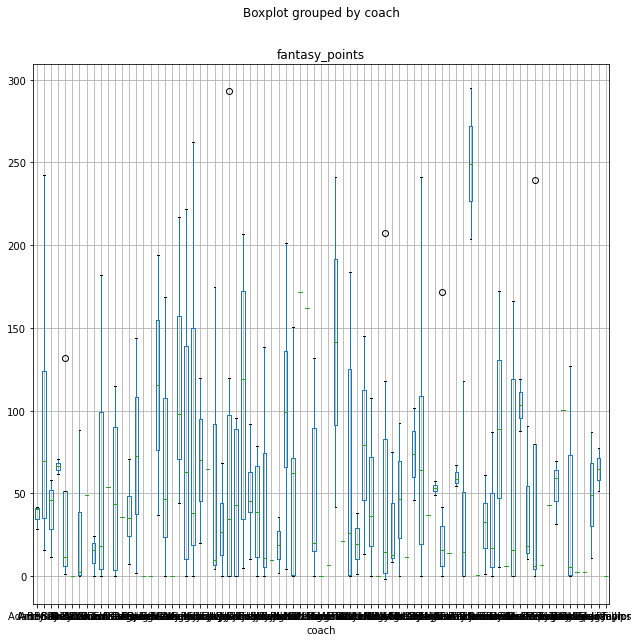

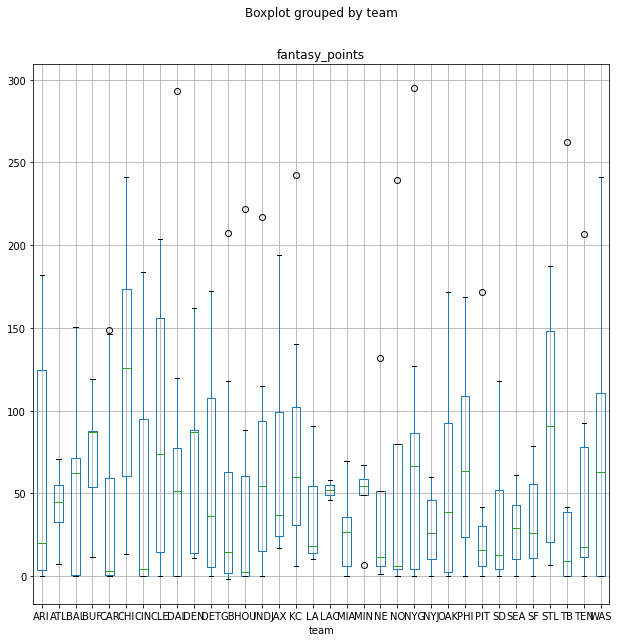

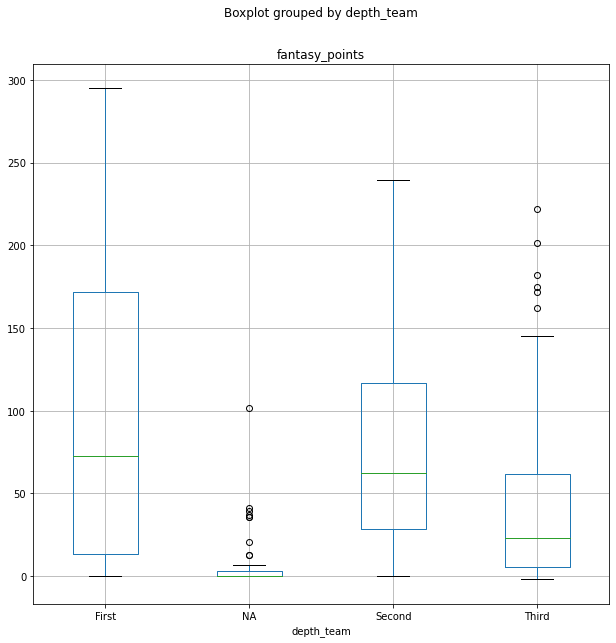

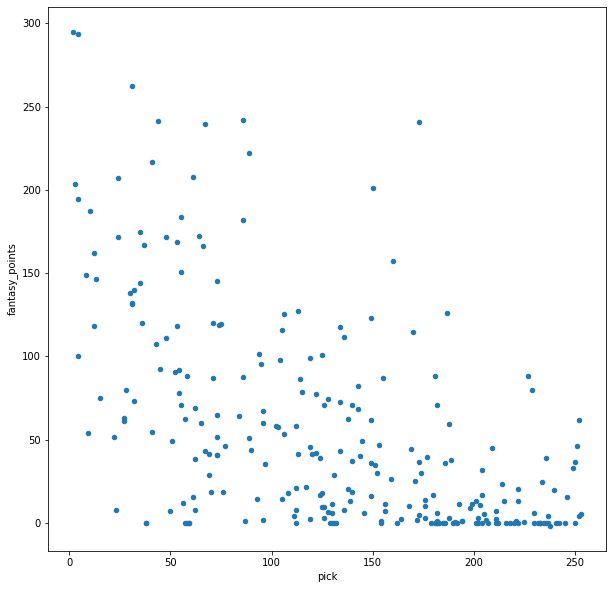

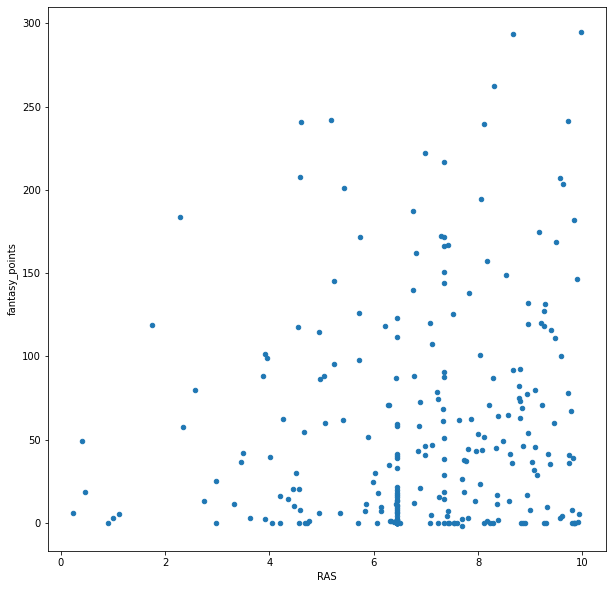

In [ ]:
rbs.boxplot(column='fantasy_points', by='coach',figsize=(10,10))
rbs.boxplot(column='fantasy_points', by='team',figsize=(10,10))
rbs.boxplot(column='fantasy_points', by='depth_team',figsize=(10,10))
rbs.plot.scatter(x='pick',y='fantasy_points',figsize=(10,10))
rbs.plot.scatter(x='RAS',y='fantasy_points',figsize=(10,10))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

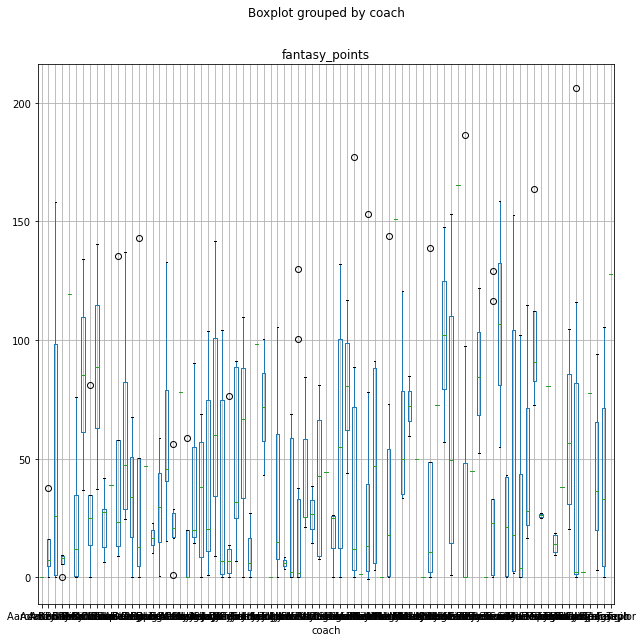

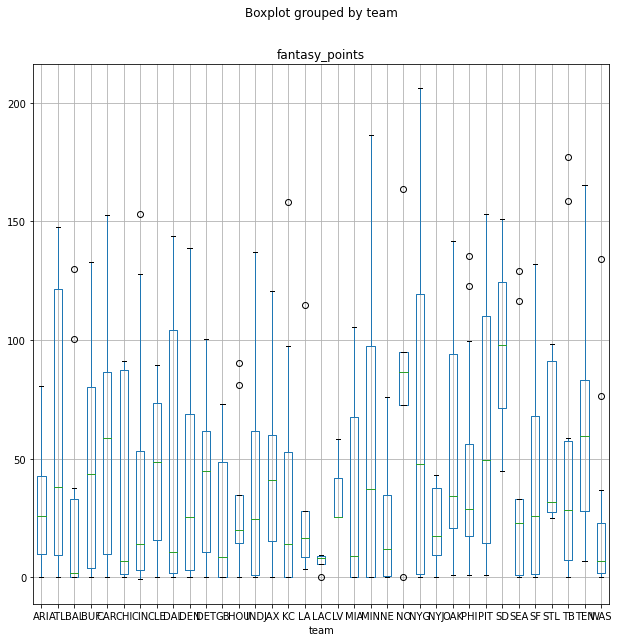

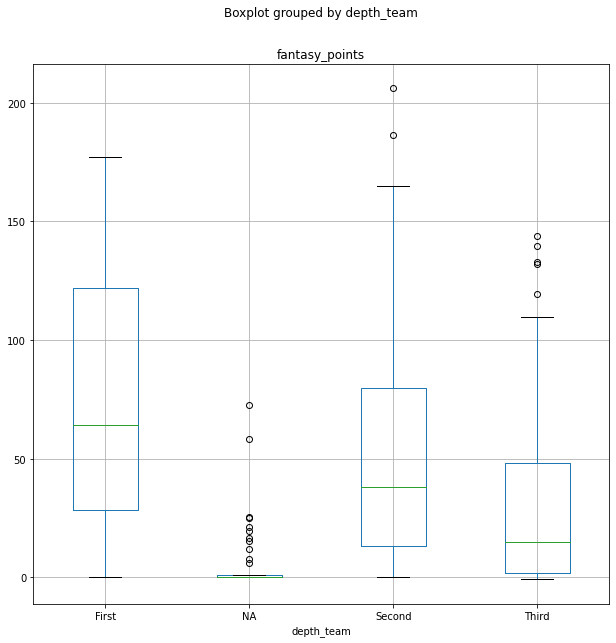

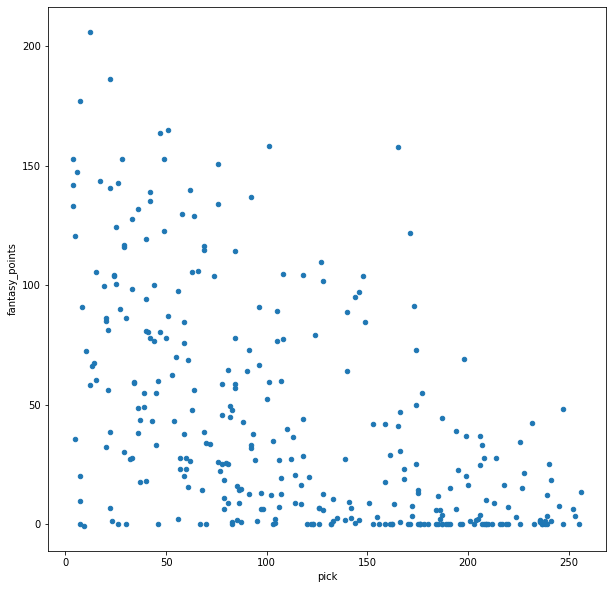

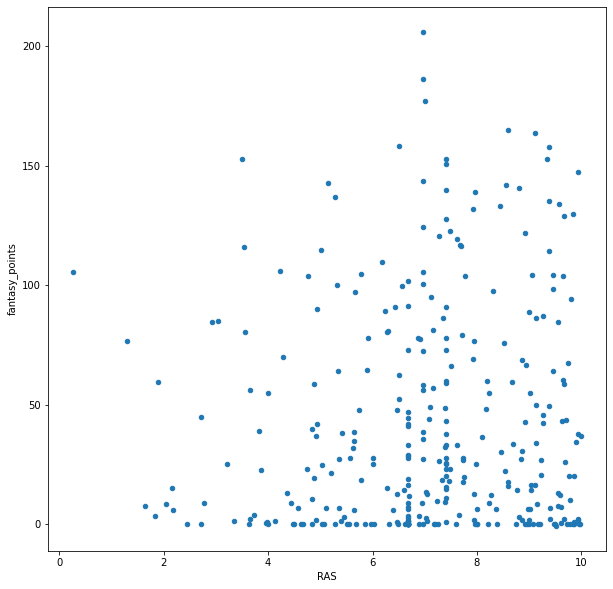

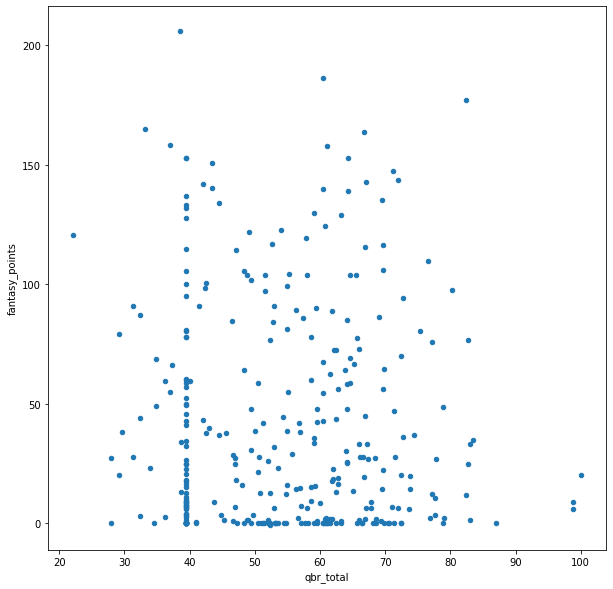

In [ ]:
wrs.boxplot(column='fantasy_points', by='coach',figsize=(10,10))
wrs.boxplot(column='fantasy_points', by='team',figsize=(10,10))
wrs.boxplot(column='fantasy_points', by='depth_team',figsize=(10,10))
wrs.plot.scatter(x='pick',y='fantasy_points',figsize=(10,10))
wrs.plot.scatter(x='RAS',y='fantasy_points',figsize=(10,10))
wrs.plot.scatter(x='qbr_total',y='fantasy_points',figsize=(10,10))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

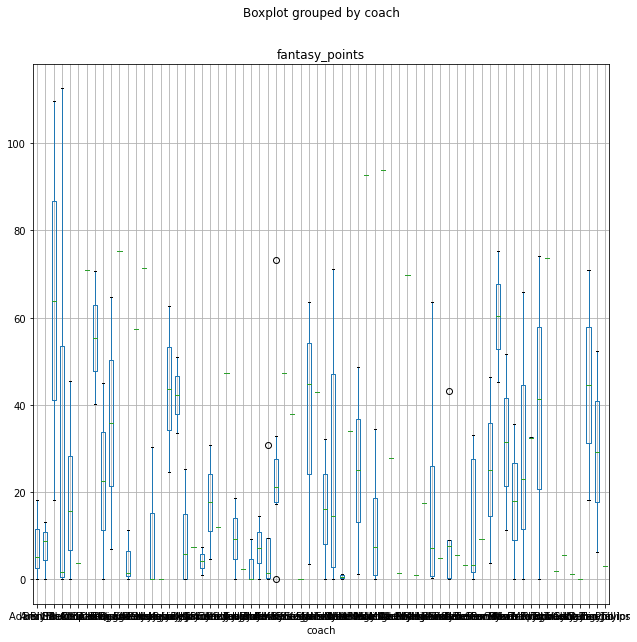

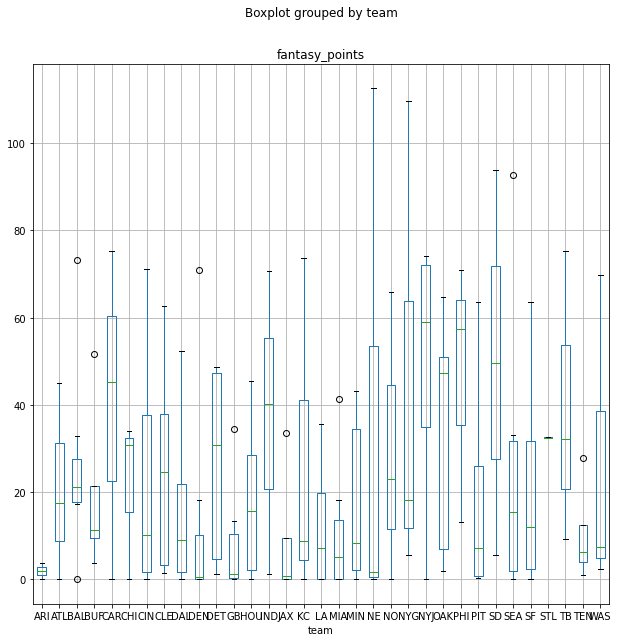

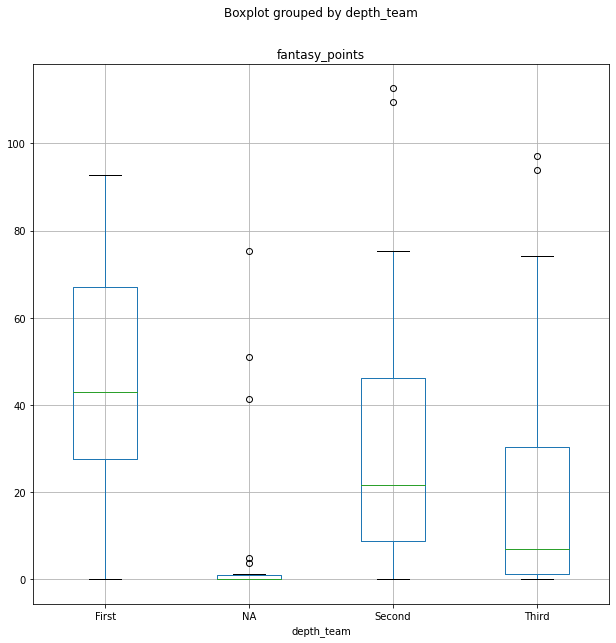

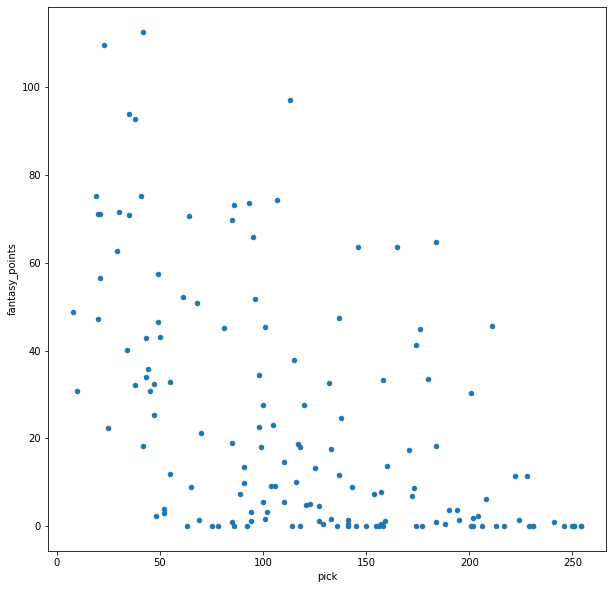

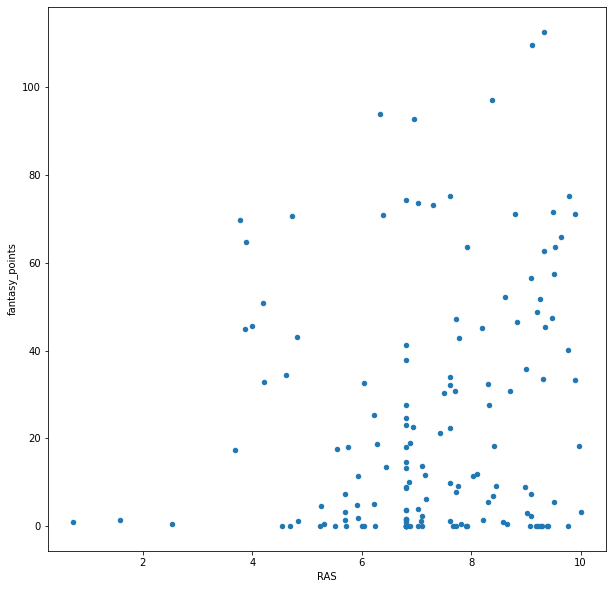

In [ ]:
tes.boxplot(column='fantasy_points', by='coach',figsize=(10,10))
tes.boxplot(column='fantasy_points', by='team',figsize=(10,10))
tes.boxplot(column='fantasy_points', by='depth_team',figsize=(10,10))
tes.plot.scatter(x='pick',y='fantasy_points',figsize=(10,10))
tes.plot.scatter(x='RAS',y='fantasy_points',figsize=(10,10))

In [ ]:
qbs.corr()

,pick,RAS,pass_rate,fantasy_points
pick,1.000000,-0.162359,0.013814,-0.663246
RAS,-0.162359,1.000000,-0.055843,0.199304
pass_rate,0.013814,-0.055843,1.000000,0.008938
fantasy_points,-0.663246,0.199304,0.008938,1.000000


In [ ]:
rbs.corr()

,pick,RAS,pass_rate,qbr_total,epa_total,qb_pass_epa,qb_run_epa,fantasy_points
pick,1.000000,-0.218054,0.053962,0.007915,0.072511,0.045992,0.046548,-0.576456
RAS,-0.218054,1.000000,-0.041740,0.020304,-0.030852,-0.034785,0.020201,0.149529
pass_rate,0.053962,-0.041740,1.000000,0.068237,0.123660,0.181922,-0.134327,0.021154
qbr_total,0.007915,0.020304,0.068237,1.000000,0.702573,0.735901,0.158432,-0.053601
epa_total,0.072511,-0.030852,0.123660,0.702573,1.000000,0.927462,0.290543,-0.067245
qb_pass_epa,0.045992,-0.034785,0.181922,0.735901,0.927462,1.000000,-0.029466,-0.050263
qb_run_epa,0.046548,0.020201,-0.134327,0.158432,0.290543,-0.029466,1.000000,-0.019630
fantasy_points,-0.576456,0.149529,0.021154,-0.053601,-0.067245,-0.050263,-0.019630,1.000000


In [ ]:
wrs.corr()

,pick,RAS,pass_rate,qbr_total,epa_total,qb_pass_epa,qb_run_epa,fantasy_points
pick,1.000000,-0.168619,0.038610,0.005729,0.052921,0.012530,0.111676,-0.542892
RAS,-0.168619,1.000000,-0.011935,0.066102,0.098684,0.094352,-0.001861,0.073404
pass_rate,0.038610,-0.011935,1.000000,-0.029291,-0.006470,0.039458,-0.094819,0.028110
qbr_total,0.005729,0.066102,-0.029291,1.000000,0.642738,0.688593,0.167406,-0.043453
epa_total,0.052921,0.098684,-0.006470,0.642738,1.000000,0.928999,0.298656,-0.050372
qb_pass_epa,0.012530,0.094352,0.039458,0.688593,0.928999,1.000000,-0.013103,-0.044076
qb_run_epa,0.111676,-0.001861,-0.094819,0.167406,0.298656,-0.013103,1.000000,-0.062068
fantasy_points,-0.542892,0.073404,0.028110,-0.043453,-0.050372,-0.044076,-0.062068,1.000000


In [ ]:
tes.corr()

,pick,RAS,pass_rate,qbr_total,epa_total,qb_pass_epa,qb_run_epa,fantasy_points
pick,1.000000,-0.355081,0.011365,0.062794,0.089164,0.039151,0.079516,-0.524920
RAS,-0.355081,1.000000,-0.053366,-0.031424,-0.086464,-0.060803,-0.013609,0.176403
pass_rate,0.011365,-0.053366,1.000000,-0.015402,0.109757,0.138891,-0.064401,-0.028472
qbr_total,0.062794,-0.031424,-0.015402,1.000000,0.619235,0.667594,0.037008,-0.103333
epa_total,0.089164,-0.086464,0.109757,0.619235,1.000000,0.929056,0.132011,-0.047199
qb_pass_epa,0.039151,-0.060803,0.138891,0.667594,0.929056,1.000000,-0.190736,-0.006436
qb_run_epa,0.079516,-0.013609,-0.064401,0.037008,0.132011,-0.190736,1.000000,-0.082067
fantasy_points,-0.524920,0.176403,-0.028472,-0.103333,-0.047199,-0.006436,-0.082067,1.000000


The Correlation Matrices and the scatterplots clearly show that RAS and espically pick position are the features that most influnce fantasy_points. Categorically, depth chart position clearly has an impact, with every position scoring higher when they are higher on the depth chart. It can also be seen that those who don't make opening day depth charts are fantasy irrelevant for at least their rookie year.

There are some differences when looking at coaches and teams. However, these two are going to be very highly correlated. For example, Bill Belichick is the current coach for the Patriots, and has been for the entierity of the data that is being looked at here. For this reason I am choosing to only include the coach variable in the models. This is because many teams have had many different coaches over this time, and they all may have wildly different philosphies when it comes to how they play rookies and if they are more pass/run heavy.

Lastly when it comes to the non-qb postions they have data that relates to the perfomance of the QB they will be playing with. This data is from the previous year for said QB, and is set to the mean of rookie qb perfomance if their QB had no data from the previous year. The Correlation matrices show overall low correlation between these stats and fantasy outcomes, however I will be keeping them in the model as preliminary testing showed a slight improvment with them, although that could just be coincidental. 

# Models

In [ ]:
! pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("NFLdata") \
    .getOrCreate()

In [ ]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import udf, col, avg
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import math
import random

In [ ]:
spark_qb=spark.createDataFrame(qbs)
spark_rb=spark.createDataFrame(rbs)
spark_wr=spark.createDataFrame(wrs)
spark_te= spark.createDataFrame(tes)

In [ ]:
#Indexers for cat variables
depthIndexer = StringIndexer(inputCol="depth_team", outputCol="indexed_depth", handleInvalid='keep')
coachIndexer = StringIndexer(inputCol="coach", outputCol="indexed_coach",handleInvalid='keep')

#OHE for indexed variables
ohe = OneHotEncoder(inputCols=['indexed_depth','indexed_coach'], outputCols=['depthOneHotEnc','coachOneHotEnc'])

#Numeric Assemblers for continous variables. Since non-qbs have extra data they have a seperate assembler 
numColumnAssembler_qb = VectorAssembler(inputCols = ['RAS','pick'], outputCol='numVector')
numColumnAssembler_nonqb = VectorAssembler(inputCols = ['RAS','pick','qbr_total','epa_total','qb_pass_epa','qb_run_epa'], outputCol='numVector')

#Feature Assembler
featureAssembler =VectorAssembler(inputCols = ['depthOneHotEnc','coachOneHotEnc','numVector'], outputCol='allFeatures')

#Random Forest
rf = RandomForestRegressor(featuresCol='allFeatures',labelCol='fantasy_points',predictionCol='pred',seed=42)
rf_qb_pipeline = Pipeline(stages=[depthIndexer,coachIndexer,ohe,numColumnAssembler_qb,featureAssembler,rf])
rf_nonqb_pipeline = Pipeline(stages=[depthIndexer,coachIndexer,ohe,numColumnAssembler_nonqb,featureAssembler,rf])

#Gradiant Boosted Tree
gbt = GBTRegressor(featuresCol='allFeatures',labelCol='fantasy_points',predictionCol='pred',seed=42,maxIter=50)
gbt_qb_pipeline = Pipeline(stages=[depthIndexer,coachIndexer,ohe,numColumnAssembler_qb,featureAssembler,gbt])
gbt_nonqb_pipeline = Pipeline(stages=[depthIndexer,coachIndexer,ohe,numColumnAssembler_nonqb,featureAssembler,gbt])

In [ ]:
#https://medium.com/storebrand-tech/random-search-in-spark-ml-5370dc908bd7 for random grid
class RandomGridBuilder: 
  '''Grid builder for random search. Sets up grids for use in CrossValidator in Spark using values randomly sampled from user-provided distributions.
  Distributions should be provided as lambda functions, so that the numbers are generated at call time.
  
  Parameters:
    num_models: Integer (Python) - number of models to generate hyperparameters for
    seed: Integer (Python) - seed (optional, default is None)
    
  Returns:
    param_map: list of parameter maps to use in cross validation.
    
  Example usage:
    from pyspark.ml.classification import LogisticRegression
    lr = LogisticRegression()
    paramGrid = RandomGridBuilder(2)\
               .addDistr(lr.regParam, lambda: np.random.rand()) \
               .addDistr(lr.maxIter, lambda : np.random.randint(10))\
               .build()
               
    Returns similar output as Spark ML class ParamGridBuilder and can be used in its place. The above paramGrid provides random hyperparameters for 2 models.
    '''
  
  def __init__(self, num_models, seed=None):
    self._param_grid = {}
    self.num_models = num_models
    self.seed = seed
    
  def addDistr(self, param, distr_generator):
    '''Add distribution based on dictionary generated by function passed to addDistr.'''
    
    if 'pyspark.ml.param.Param' in str(type(param)):
      self._param_grid[param] = distr_generator
    else:
      raise TypeError('param must be an instance of Param')

    return self
  
  def build(self):    
    param_map = []
    for n in range(self.num_models):
      if self.seed:
        # Set seeds for both numpy and random in case either is used for the random distribution
        np.random.seed(self.seed + n)
        random.seed(self.seed + n)
      param_dict = {}
      for param, distr in self._param_grid.items():
        param_dict[param] = distr()
      param_map.append(param_dict)
    
    return param_map

In [ ]:
randomParams = RandomGridBuilder(15)\
                 .addDistr(rf.featureSubsetStrategy, lambda : str(np.random.rand()))\
                 .addDistr(rf.maxDepth, lambda : np.random.randint(5, 20))\
                 .addDistr(rf.numTrees, lambda : math.floor(500*np.random.power(1)))\
                 .build()

In [ ]:
#Not Currently used, instead using randomParams for rf, keeping for testing/comparing performance
paramGrid = ParamGridBuilder() \
  .addGrid(rf.maxDepth, [5,6,7,8,9])\
  .addGrid(rf.numTrees,[50,60,70,80,90,100,110])\
  .build()
#Used for GBT
gbt_paramGrid = ParamGridBuilder() \
  .addGrid(gbt.maxDepth, [5,6,7,8,9])\
  .build()

evaluator = RegressionEvaluator(
    labelCol="fantasy_points", predictionCol="pred", metricName="rmse")

rf_crossval_qb = CrossValidator(estimator=rf_qb_pipeline,
                          estimatorParamMaps=randomParams,
                          evaluator=evaluator,
                          numFolds=7,
                          parallelism=2)
gbt_crossval_qb = CrossValidator(estimator=gbt_qb_pipeline,
                          estimatorParamMaps=gbt_paramGrid,
                          evaluator=evaluator,
                          numFolds=7,
                          parallelism=2)
rf_crossval_nonqb = CrossValidator(estimator=rf_nonqb_pipeline,
                          estimatorParamMaps=randomParams,
                          evaluator=evaluator,
                          numFolds=7,
                          parallelism=2)
gbt_crossval_nonqb = CrossValidator(estimator=gbt_nonqb_pipeline,
                          estimatorParamMaps=gbt_paramGrid,
                          evaluator=evaluator,
                          numFolds=7,
                          parallelism=2)

In [ ]:
(train_qb, test_qb) = spark_qb.randomSplit([0.8,0.2])
qb_cv = rf_crossval_qb.fit(train_qb)
qb_rf_pred = qb_cv.transform(train_qb)
qb_rf_test_pred = qb_cv.transform(test_qb)

In [ ]:
qb_cv_gbt = gbt_crossval_qb.fit(train_qb)
qb_gbt_pred = qb_cv_gbt.transform(train_qb)
qb_gbt_test_pred = qb_cv_gbt.transform(test_qb)

In [ ]:
(train_rb, test_rb) = spark_rb.randomSplit([0.8,0.2])
rb_cv = rf_crossval_nonqb.fit(train_rb)
rb_rf_pred = rb_cv.transform(train_rb)
rb_rf_test_pred = rb_cv.transform(test_rb)

In [ ]:
rb_cv_gbt = gbt_crossval_nonqb.fit(train_rb)
rb_gbt_pred = rb_cv_gbt.transform(train_rb)
rb_gbt_test_pred = rb_cv_gbt.transform(test_rb)

In [ ]:
(train_wr, test_wr) = spark_wr.randomSplit([0.8,0.2])
wr_cv = rf_crossval_nonqb.fit(train_wr)
wr_rf_pred = wr_cv.transform(train_wr)
wr_rf_test_pred = wr_cv.transform(test_wr)

In [ ]:
wr_cv_gbt = gbt_crossval_nonqb.fit(train_wr)
wr_gbt_pred = wr_cv_gbt.transform(train_wr)
wr_gbt_test_pred = wr_cv_gbt.transform(test_wr)

In [ ]:
(train_te, test_te) = spark_te.randomSplit([0.8,0.2])
te_cv = rf_crossval_nonqb.fit(train_te)
te_rf_pred = te_cv.transform(train_te)
te_rf_test_pred = te_cv.transform(test_te)

In [ ]:
te_cv_gbt = gbt_crossval_nonqb.fit(train_te)
te_gbt_pred = te_cv_gbt.transform(train_te)
te_gbt_test_pred = te_cv_gbt.transform(test_te)

# Results

In [ ]:
#https://stackoverflow.com/questions/61175772/pyspark-calculate-rmse-between-actuals-and-predictions-for-a-groupby-asserti for RMSE calculation
def calculate_rmse(df, actual_column, prediction_column):
    RMSE = udf(lambda x, y: ((x - y) ** 2))
    df = df.withColumn(
        "RMSE", RMSE(col(actual_column), col(prediction_column))
    )
    rmse = df.select(avg("RMSE") ** 0.5).collect()
    rmse = rmse[0]["POWER(avg(RMSE), 0.5)"]
    return rmse

22.128769027008737
50.581947123288884


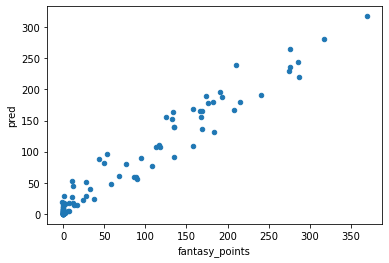

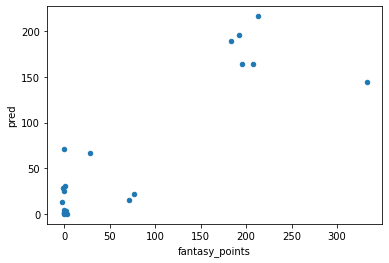

In [ ]:
print(calculate_rmse(qb_rf_pred, 'fantasy_points', 'pred'))
print(calculate_rmse(qb_rf_test_pred, 'fantasy_points', 'pred'))
panda_qb_pred = qb_rf_pred.toPandas()
panda_qb_test_pred = qb_rf_test_pred.toPandas()
panda_qb_pred.plot.scatter('fantasy_points','pred')
panda_qb_test_pred.plot.scatter('fantasy_points','pred')

20.563881139263582
50.12956695711969


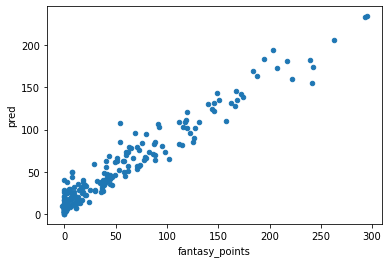

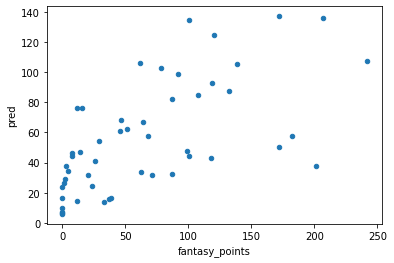

In [ ]:
print(calculate_rmse(rb_rf_pred, 'fantasy_points', 'pred'))
print(calculate_rmse(rb_rf_test_pred, 'fantasy_points', 'pred'))
panda_rb_pred = rb_rf_pred.toPandas()
panda_rb_test_pred = rb_rf_test_pred.toPandas()
panda_rb_pred.plot.scatter('fantasy_points','pred')
panda_rb_test_pred.plot.scatter('fantasy_points','pred')

24.42529209010654
43.145188143848536


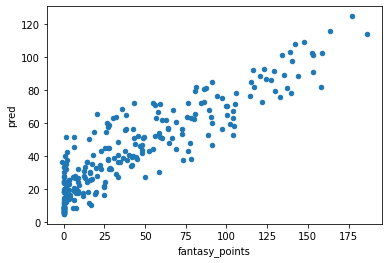

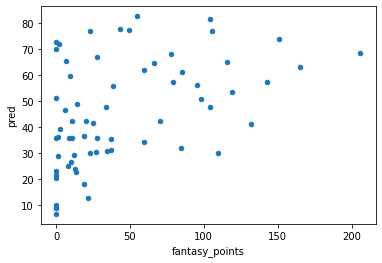

In [ ]:
print(calculate_rmse(wr_rf_pred, 'fantasy_points', 'pred'))
print(calculate_rmse(wr_rf_test_pred, 'fantasy_points', 'pred'))
panda_wr_pred = wr_rf_pred.toPandas()
panda_wr_test_pred = wr_rf_test_pred.toPandas()
panda_wr_pred.plot.scatter('fantasy_points','pred')
panda_wr_test_pred.plot.scatter('fantasy_points','pred')

10.594615234954544
28.260726633881422


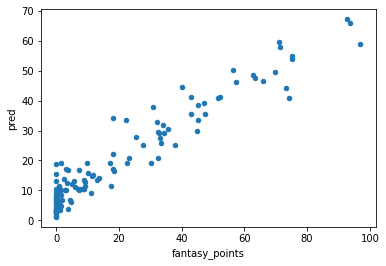

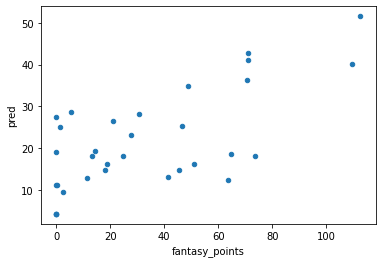

In [ ]:
print(calculate_rmse(te_rf_pred, 'fantasy_points', 'pred'))
print(calculate_rmse(te_rf_test_pred, 'fantasy_points', 'pred'))
panda_te_pred = te_rf_pred.toPandas()
panda_te_test_pred = te_rf_test_pred.toPandas()
panda_te_pred.plot.scatter('fantasy_points','pred')
panda_te_test_pred.plot.scatter('fantasy_points','pred')

5.867763713528945
46.57892068715166


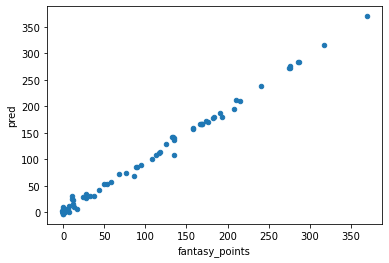

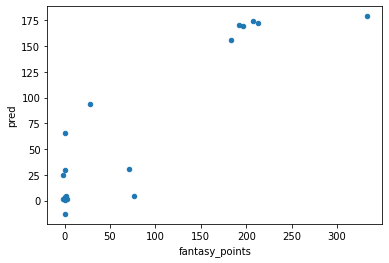

In [ ]:
print(calculate_rmse(qb_gbt_pred, 'fantasy_points', 'pred'))
print(calculate_rmse(qb_gbt_test_pred, 'fantasy_points', 'pred'))
panda_qb_pred = qb_gbt_pred.toPandas()
panda_qb_test_pred = qb_gbt_test_pred.toPandas()
panda_qb_pred.plot.scatter('fantasy_points','pred')
panda_qb_test_pred.plot.scatter('fantasy_points','pred')

13.058653937927359
55.4707595593584


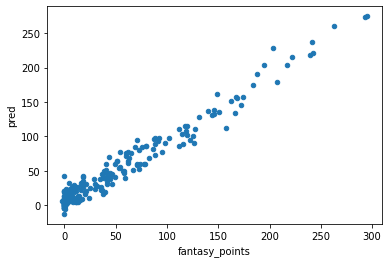

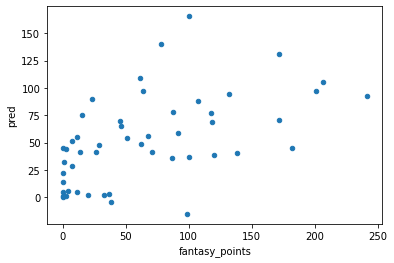

In [ ]:
print(calculate_rmse(rb_gbt_pred, 'fantasy_points', 'pred'))
print(calculate_rmse(rb_gbt_test_pred, 'fantasy_points', 'pred'))
panda_rb_pred = rb_gbt_pred.toPandas()
panda_rb_test_pred = rb_gbt_test_pred.toPandas()
panda_rb_pred.plot.scatter('fantasy_points','pred')
panda_rb_test_pred.plot.scatter('fantasy_points','pred')

9.354503439867564
48.58192817547933


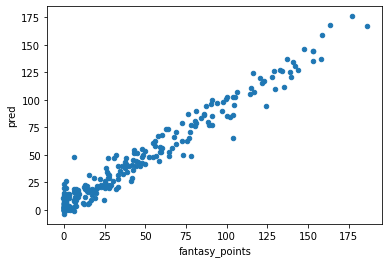

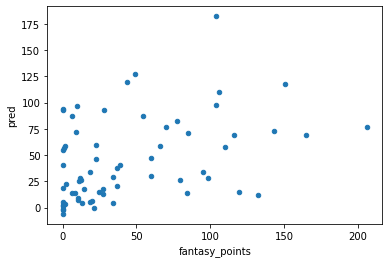

In [ ]:
print(calculate_rmse(wr_gbt_pred, 'fantasy_points', 'pred'))
print(calculate_rmse(wr_gbt_test_pred, 'fantasy_points', 'pred'))
panda_wr_pred = wr_gbt_pred.toPandas()
panda_wr_test_pred = wr_gbt_test_pred.toPandas()
panda_wr_pred.plot.scatter('fantasy_points','pred')
panda_wr_test_pred.plot.scatter('fantasy_points','pred')

1.5281912664299606
28.56762733448566


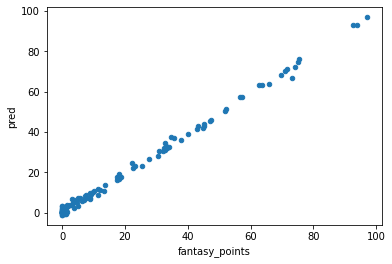

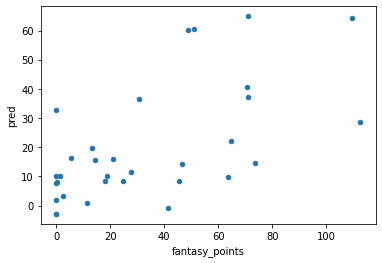

In [ ]:
print(calculate_rmse(te_gbt_pred, 'fantasy_points', 'pred'))
print(calculate_rmse(te_gbt_test_pred, 'fantasy_points', 'pred'))
panda_te_pred = te_gbt_pred.toPandas()
panda_te_test_pred = te_gbt_test_pred.toPandas()
panda_te_pred.plot.scatter('fantasy_points','pred')
panda_te_test_pred.plot.scatter('fantasy_points','pred')

The Results of the models are decent at best. The bigest problem is clearly overfitting, I have tried to do a few things such as increasing folds and altering some parameters, but they always seem to have this problem to some extent, where testing data is usually 2x the RMSE of the training data. I can imagine this being to data such as coach not being seen in the training data and that messing with testing predictions. Best seen perfromence on testing data I've gotten lead to an decrease in perfromance on the training, which may be better overall still given the relative unpredictability of the NFL. 

There are many changes I would make to try and improve perfromance, the biggest of which would be to add new data for predictions, such as college stats, offinsive ranking of previous year etc. Also changing coach into either another categorical variable with fewer options (such as just spliting into offisive or defensive minded coaches) or replacing it with various countinous variables would likely help. After doing modeling I went back and added pass rate for the coaches, however I didn't end up including it in a model as that alone showed little correlation with any fantasy performance.

Another improvement that could be done would be to find a better way of replacing null values for the previous year qb stats and for RAS scores. 2020 and 2021 did not have a combine due to covid, and thus had no RAS scores for prospects, so their RAS data was replaced with the average RAS score at their postion for that area of the draft. That is far from a good solution however, as even without combine score their would be better ways of estimating RAS score for individual prospects, I just didn't have the time to go and develop a system for doing so.

In [ ]:
college_qbr = pd.read_csv('https://raw.githubusercontent.com/JackLich10/nfl-draft-data/main/college_qbr.csv')
rec_stats = pd.read_csv('https://raw.githubusercontent.com/Jswirls/rookie_fantasy_proj/main/data/rec_stats.csv')
rush_stats = pd.read_csv('/content/rush.csv')
#college_ids = pd.read_csv('https://github.com/JackLich10/nfl-draft-data/blob/main/ids.csv')